In [44]:
from collections import Counter
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import time

from sklearn.model_selection import train_test_split
from nltk import word_tokenize

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np

from sklearn.manifold import TSNE
import itertools

from itertools import combinations
import csv

import re
import string
import pandas as pd

# Load and Downsample Data

In [45]:
# NPR correspondent/reporter archive links
urls = [
    'https://www.npr.org/people/1931801/linda-wertheimer/archive',
    'https://www.npr.org/people/2101212/lakshmi-singh/archive',
    'https://www.npr.org/people/467974737/brett-neely/archive',
    'https://www.npr.org/people/2100955/patti-neighmond/archive',
    'https://www.npr.org/people/392602474/domenico-montanaro/archive',
    'https://www.npr.org/people/1936301/john-burnett/archive',
    'https://www.npr.org/people/348780034/nicole-cohen/archive',
    'https://www.npr.org/people/349241810/rose-friedman/archive',
        
    'https://www.npr.org/people/2100689/christopher-joyce/archive',
    'https://www.npr.org/people/384067907/rebecca-hersher/archive',
         
   'https://www.npr.org/people/468930062/jane-greenhalgh/archive',

   'https://www.npr.org/people/536711382/gisele-grayson/archive',
   'https://www.npr.org/people/578890280/rhitu-chatterjee/archive',

   'https://www.npr.org/people/348730771/aarti-shahani/archive',
   'https://www.npr.org/people/676406186/sacha-pfeiffer/archive',
   'https://www.npr.org/people/96022165/yuki-noguchi/archive',
   'https://www.npr.org/people/131724812/scott-neuman/archive',

   'https://www.npr.org/people/448294256/sarah-mccammon/archive',
   'https://www.npr.org/people/2100815/jennifer-ludden/archive',
   'https://www.npr.org/people/122805042/tamara-keith/archive',
   'https://www.npr.org/people/2100569/richard-gonzales/archive',

    'https://www.npr.org/people/5201175/michel-martin/archive',
    'https://www.npr.org/people/2100615/jon-hamilton/archive',
    'https://www.npr.org/people/2101154/ari-shapiro/archive'
    'https://www.npr.org/people/2100438/debbie-elliott/archive',
    'https://www.npr.org/people/348778932/michaeleen-doucleff/archive',
    'https://www.npr.org/people/7569853/russell-lewis/archive',
    'https://www.npr.org/people/348766539/greg-myre/archive',
    'https://www.npr.org/people/473143808/alison-kodjak/archive', 
    'https://www.npr.org/people/2788801/scott-horsley/archive',
    'https://www.npr.org/people/2100631/richard-harris/archive',
    'https://www.npr.org/people/146944972/rob-stein/archive',
    'https://www.npr.org/people/544275644/ryan-lucas/archive',
    'https://www.npr.org/people/2101062/philip-reeves/archive',
    'https://www.npr.org/people/279612138/geoff-brumfiel/archive',
    'https://www.npr.org/people/1930203/ron-elving/archive',
    'https://www.npr.org/people/2100569/richard-gonzales/archive']

names = []
for url in urls:
    names.append(url.split('/')[5].replace('-', ' '))

In [46]:
# Create list of reporter names
reporters = [name.split()[1].upper() for name in names]

In [47]:
npr_bystory_df = pd.read_csv('npr_df.csv')

In [48]:
# Group news pieces by speaker
grps = npr_bystory_df[npr_bystory_df['speaker'].isin(reporters)].groupby('speaker')

# A list of the speakers who have more than sample_size articles
full_article_speakers = []

sample_size = 120
culled_npr_bystory = []
for grp in grps:
    if len(grp[1])>sample_size:
        culled_npr_bystory.append(grp[1].sample(n=sample_size))
        print(grp[0], len(grp[1]))
        full_article_speakers.append(grp[0])

BRUMFIEL 166
BURNETT 440
ELVING 280
GONZALES 293
HAMILTON 361
HARRIS 479
HORSLEY 744
JOYCE 399
KEITH 709
KODJAK 128
LUDDEN 333
MARTIN 186
MCCAMMON 237
MONTANARO 152
NEIGHMOND 255
NOGUCHI 446
REEVES 605
SHAHANI 199
SHAPIRO 638
STEIN 224
WERTHEIMER 266


In [49]:
# Create dataframe of sample_size number of articles for each reporter
culled_npr_bystory_df = pd.concat(culled_npr_bystory)

In [50]:
culled_npr_bystory_df= culled_npr_bystory_df.drop(['Unnamed: 0'],  axis=1)

# Functions

## Clustering

In [67]:
# Clusters document vectors with a range of k values and returns scores, and models
def make_clusters(doc_vecs_df, **kwargs):
    nclusts = []
    sscores = [] 
    avg_obs = []
    obs_std = []
    models = []
    labels = []
    
    if 'max_clusters' in kwargs:
        max_clusters = min(len(doc_vecs_df),kwargs['max_clusters'])
    else:
        max_clusters = min(len(doc_vecs_df), 40)
        
    for no in range(2,max_clusters,1):
        t1 = time.time()
        model = KMeans(n_clusters=no, random_state=43).fit(doc_vecs_df)
        fdv_clusters = model.predict(doc_vecs_df)
        nclusts.append(no)
        sscores.append(silhouette_score(doc_vecs_df, fdv_clusters, metric='cosine'))
        avg_obs.append(pd.value_counts(fdv_clusters).mean())
        obs_std.append(pd.value_counts(fdv_clusters).std())
        models.append(model)
        labels.append(fdv_clusters)
        
    return models, pd.DataFrame({'nclusts':nclusts, 'sscores':sscores, 'avg_obs':avg_obs, 'obs_std':obs_std})

In [52]:
# Visualize clustering overall as sil plots
def make_sil_plot(df, **kwargs):
    obsstd1 = [ i+j for i,j in zip(df['avg_obs'],df['obs_std'])]
    stdneg = [ i-j for i,j in zip(df['avg_obs'],df['obs_std'])]

    fig, ax = fig, ax = plt.subplots(figsize=(6,4))

    ax2 = ax.twinx()
    ax = sns.lineplot(df['nclusts'], df['sscores'],color='g', label='Sil. Score', linewidth=2, ax=ax)
    ax2 =sns.lineplot(df['nclusts'], df['avg_obs'],color='purple',label='Avg obs per cluster', linewidth=2)
    sns.lineplot(df['nclusts'],obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
    sns.lineplot(df['nclusts'],stdneg,color='r', linewidth=.6)

    ax.set_ylabel('Sil. Score')
    ax.set_xlabel('Number of Clusters')
    ax.axvline(x=df['nclusts'].iloc[df['sscores'].idxmax()],color='r',linestyle='dotted')

    ax.legend(loc='lower left')
    ax2.legend(loc='upper right')
    plt.ylabel('Average Observation per cluster')
    plt.xlabel('Number of Clusters')
    plt.title('Silhouette Scores by Number of Clusters',fontsize=20)

    if 'save_name' in kwargs:
        plt.savefig(kwargs['save_name'], format='svg', bbox_inches='tight')

In [53]:
# Build TSNE axes from vectors for cluster viz
def fit_tsne(num_clusters, d2v_vecs_df,X_train, **kwargs):
    tsne = TSNE(n_components=2, random_state=43)
    
    #create dataframe for plotting, add components,labels
    tsne_plot_df = pd.DataFrame()
    tsne_plot_df['original'] = X_train['cleaned_text']
    tsne_plot_df['ids'] = X_train['ids']

    #get cluster assignments from KMeans
    if ('assigned_labels' in kwargs):
        d2v_clusterst = kwargs['assigned_labels']
    else:
        d2v_clusterst = KMeans(n_clusters=num_clusters, random_state=43).fit_predict(d2v_vecs_df)

    tsne_plot_df['clusters'] = d2v_clusterst

    #fit transform doc2vec word vectors
    Yt = tsne.fit_transform(d2v_vecs_df)
    tsne_plot_df['TSNE_1'] = Yt[:,0]
    tsne_plot_df['TSNE_2'] = Yt[:,1]
    return tsne_plot_df

In [54]:
# Produce TSNE plot
def make_tsne_plot(tsne_plot_df, num_clusters, **kwargs):
    plt.figure(figsize=(6,5))
    sns.despine(left=True)

    sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters', data=tsne_plot_df, palette='BrBG', legend='full',
                    edgecolor='black', s=40, alpha=.7).set_title('KMeans {} clusters'.format(num_clusters))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([tsne_plot_df['TSNE_1'].min()*1.2, tsne_plot_df['TSNE_1'].max()*1.2])
    plt.ylim([tsne_plot_df['TSNE_2'].min()*1.2, tsne_plot_df['TSNE_2'].max()*1.2])
    
    if 'save_name' in kwargs:
        plt.savefig(kwargs['save_name'], format='svg', bbox_inches='tight')


# Model Tuning

In [ ]:
# Using identified parameters, exhaustively search the reporter combinations
# looking for a set of reporters that best describe the news space and print
# results to csv.

speaker_lists = list(combinations(full_article_speakers, 10))

with open('npr_lsa_rep_comb3.csv', 'w') as csvfile:
    for ik, speaker_list in enumerate(speaker_lists[470+478:]):
        X_train, X_test = train_test_split(culled_npr_bystory_df[culled_npr_bystory_df['speaker'].isin(speaker_list)])

        X_train = pd.DataFrame(X_train, columns = culled_npr_bystory_df.columns)
        X_test = pd.DataFrame(X_test, columns = culled_npr_bystory_df.columns)

        vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than half the paragraphs
                                     min_df=3, # only use words that appear at least twice
                                     stop_words='english', 
                                     ngram_range = (1,2),
                                     lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                     use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                     norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                     smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                    )

        #Applying the vectorizer
        npr_tfidf=vectorizer.fit(X_train['comment_text'])

        #splitting into training and test sets
        npr_tfidf_train=vectorizer.transform(X_train['comment_text'])

        #Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
        svd= TruncatedSVD(300)
        lsa = make_pipeline(svd, Normalizer(copy=False))
        # Run SVD on the training data, then project the training data.
        npr_lsa = lsa.fit(npr_tfidf_train)

        npr_tfidf_lsa_train = npr_lsa.transform(npr_tfidf_train)

        kmeans_mdls, df_clusters = make_clusters(npr_tfidf_lsa_train)

        num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].idxmax()]

        row = [df_clusters['sscores'].max(), num_clusters]+ list(speaker_list)
        csv.writer(csvfile).writerow(row)
        
        print(ik)
        print('score:', df_clusters['sscores'].max(), 'number of clusters:', num_clusters)
        print(speaker_list)


# Analysis

## Load & Prep Data

In [55]:
# Load csv of exhaustive search
df_lsa = pd.read_csv('npr_lsa_rep_comb.csv')
df_lsa.columns = ['score', 'clusters'] + ['reporter'+str(ik) for ik in range(1,11)]


### Choose Speaker Set

In [56]:
# order by score
top_lsa = df_lsa.sort_values(by = 'score', ascending=False)

In [57]:
# choose speaker list to look at
ik = 0
speaker_list = top_lsa.iloc[ik, ~top_lsa.columns.isin(['score, clusters'])]

### Split train and test sets

In [58]:
X_train, X_test = train_test_split(culled_npr_bystory_df[culled_npr_bystory_df['speaker'].isin(speaker_list)])
X_train = pd.DataFrame(X_train, columns = culled_npr_bystory_df.columns)
X_test = pd.DataFrame(X_test, columns = culled_npr_bystory_df.columns)
   
y_train = X_train['speaker']
y_test = X_test['speaker']

### Build LSA representations

In [62]:
vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than half the paragraphs
                                     min_df=3, # only use words that appear at least twice
                                     stop_words='english', 
                                     ngram_range = (1,2),
                                     lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                     use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                     norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                     smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                    )

#Applying the vectorizer
vectorizer.fit(X_train['comment_text'])

#splitting into training and test sets
npr_tfidf_train=vectorizer.transform(X_train['comment_text'])
npr_tfidf_test=vectorizer.transform(X_test['comment_text'])

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(300)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
lsa.fit(npr_tfidf_train)

npr_tfidf_lsa_train = pd.DataFrame(lsa.transform(npr_tfidf_train))
npr_tfidf_lsa_test = pd.DataFrame(lsa.transform(npr_tfidf_test))

## Cluster

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  app.launch_new_instance()


score: 0.11427072073986841 number of clusters: 39


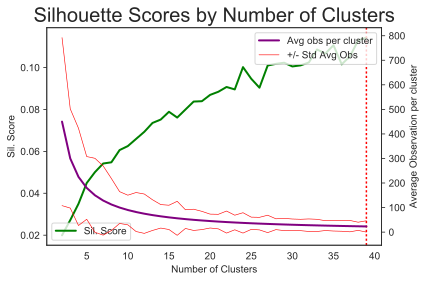

In [63]:
kmeans_mdls, df_clusters = make_clusters(npr_tfidf_lsa_train)
make_sil_plot(df_clusters)#, save_name = 'silplot_run_lsa_summary'+str(ik)+'.svg')
    
num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].idxmax()]
    
kmean_labels = kmeans_mdls[df_clusters['sscores'].idxmax()].predict(npr_tfidf_lsa_train.iloc[:, ~npr_tfidf_lsa_train.columns.isin(['labels', 'speaker', 'title', 'labels_sub'])])

print('score:', df_clusters['sscores'].max(), 'number of clusters:', num_clusters)

### Plot with TSNE

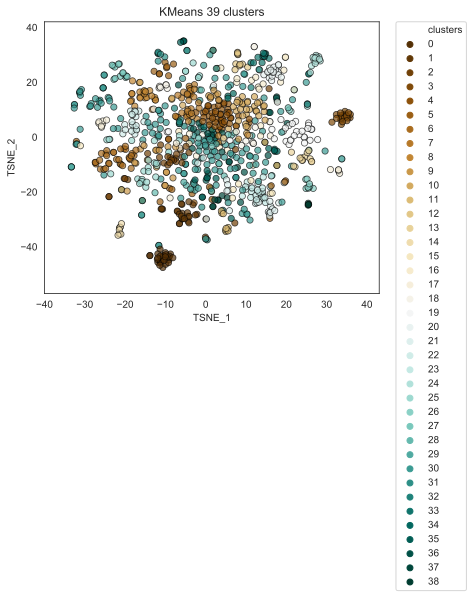

In [64]:
tsne_plot_df = fit_tsne(num_clusters, npr_tfidf_lsa_train.iloc[:, ~npr_tfidf_lsa_train.columns.isin(['labels', 'speaker', 'title', 'labels_sub'])],X_train.iloc[:, ~X_train.columns.isin(['labels', 'speaker'])], assigned_labels = kmean_labels)
make_tsne_plot(tsne_plot_df, num_clusters)#, save_name = 'tsne_kmeans_bestreps_'+str(ik)+'_'+str(num_clusters)+'.svg')


### Analyze Clusters

In [65]:
X_train['labels'] = kmeans_mdls[num_clusters-2].predict(npr_tfidf_lsa_train.iloc[:, ~npr_tfidf_lsa_train.columns.isin(['labels_sub','labels', 'speaker','title'])])
npr_tfidf_lsa_train['labels'] = kmeans_mdls[num_clusters-2].predict(npr_tfidf_lsa_train.iloc[:, ~npr_tfidf_lsa_train.columns.isin(['labels_sub','labels', 'speaker','title'])])

npr_tfidf_lsa_train['speaker'] = X_train['speaker'].values
npr_tfidf_lsa_train['title'] = X_train['title'].values

label_grps = npr_tfidf_lsa_train.groupby('labels')
for grp in label_grps:
    print( grp[0], len(grp[1]))
    speaker_groups = grp[1].groupby('speaker')
    for grp2 in speaker_groups:
        print(grp2[0], len(grp2[1]))
    print('\n')

0 26
MARTIN 26


1 25
HAMILTON 2
STEIN 23


2 29
GONZALES 28
SHAHANI 1


3 20
ELVING 1
HARRIS 2
SHAPIRO 17


4 48
ELVING 42
MARTIN 1
SHAPIRO 5


5 24
BURNETT 3
HAMILTON 9
HARRIS 2
SHAPIRO 1
STEIN 9


6 34
BURNETT 26
GONZALES 7
SHAPIRO 1


7 32
BRUMFIEL 1
BURNETT 1
ELVING 11
MARTIN 18
SHAPIRO 1


8 22
BRUMFIEL 21
HARRIS 1


9 29
BURNETT 6
ELVING 2
GONZALES 14
MARTIN 2
SHAHANI 1
SHAPIRO 4


10 35
ELVING 7
HARRIS 1
MARTIN 1
SHAHANI 1
SHAPIRO 25


11 10
STEIN 10


12 11
SHAHANI 10
SHAPIRO 1


13 13
HAMILTON 12
HARRIS 1


14 9
MARTIN 9


15 10
BRUMFIEL 1
GONZALES 1
HAMILTON 2
HARRIS 1
SHAPIRO 1
STEIN 4


16 18
GONZALES 1
HARRIS 1
MARTIN 1
SHAHANI 15


17 20
BURNETT 6
ELVING 2
GONZALES 3
HAMILTON 1
HARRIS 7
SHAPIRO 1


18 21
BRUMFIEL 4
SHAHANI 10
SHAPIRO 7


19 31
BRUMFIEL 6
HAMILTON 1
HARRIS 22
SHAHANI 1
STEIN 1


20 19
SHAHANI 18
SHAPIRO 1


21 18
BRUMFIEL 1
HAMILTON 7
HARRIS 1
STEIN 9


22 23
BRUMFIEL 8
BURNETT 1
GONZALES 1
HAMILTON 4
HARRIS 7
SHAHANI 1
STEIN 1


23 26
BRUMFIEL 1
HAMILTON

### Clustering Clusters

In [69]:
split_labels = []
d = {}
score_to_beat = max(.2, df_clusters['sscores'].max())
for ik, grp in enumerate(label_grps):
    tmp_df = grp[1].iloc[:, ~grp[1].columns.isin(['labels', 'speaker', 'title', 'labels_sub'])]
    kmeans_mdls2, df_clusters2 = make_clusters(tmp_df, max_clusters = 8)
    num_clusters2 = df_clusters2['nclusts'].iloc[df_clusters2['sscores'].idxmax()]
    
    # adding sub-label if cluster scored well
    if df_clusters2['sscores'].max()>score_to_beat:
        preds = kmeans_mdls2[df_clusters2['sscores'].idxmax()].predict(tmp_df)
        new_labels = [(ik+1)*100 + im for im in preds]
    else:
        new_labels = [(ik+1)*100 for im in grp[1]['labels']]
    for ip, im in enumerate(tmp_df.index):
        d[im] = new_labels[ip]
        
    # print summary information
    print('cluster:', grp[0], 'size:', len(grp[1]))
    print(max(df_clusters2['sscores']),num_clusters2, '\n')
    speaker_groups = grp[1].groupby('speaker')
    for grp2 in speaker_groups:
        print(grp2[0], len(grp2[1]))
    print('\n')
    
# consolidate new labels    
split_labels = [d[ik] for ik in range(len(d.keys()))]
conv_d = {key:ik for ik, key in enumerate(list(set(split_labels)))}
new_labels = [conv_d[label] for label in split_labels]

npr_tfidf_lsa_train['labels_sub'] = new_labels

# report on new clusters
labels_grps = npr_tfidf_lsa_train.groupby('labels')
for grp0 in labels_grps:
    print('cluster:', grp0[0], 'size:', len(grp0[1]))
    labels_sub_grps2 = grp0[1].groupby('labels_sub')
    for grp in labels_sub_grps2:
        print('subcluster:', grp[0], 'size:', len(grp[1]))
        speaker_groups = grp[1].groupby('speaker')
        for grp2 in speaker_groups:
            print('speaker:', grp2[0], 'number of articles:', len(grp2[1]))
            print(grp2[1][['speaker', 'title']])
        print('\n')
    print('\n')   


cluster: 0 size: 26
0.24383037181471157 3 

MARTIN 26


cluster: 1 size: 25
0.32523452228531347 5 

HAMILTON 2
STEIN 23


cluster: 2 size: 29
0.1642346084114543 2 

GONZALES 28
SHAHANI 1


cluster: 3 size: 20
0.4088990157639866 2 

ELVING 1
HARRIS 2
SHAPIRO 17


cluster: 4 size: 48
0.06891736652453966 2 

ELVING 42
MARTIN 1
SHAPIRO 5


cluster: 5 size: 24
0.14509566794230488 5 

BURNETT 3
HAMILTON 9
HARRIS 2
SHAPIRO 1
STEIN 9


cluster: 6 size: 34
0.19866648476346746 7 

BURNETT 26
GONZALES 7
SHAPIRO 1


cluster: 7 size: 32
0.1865596411704733 2 

BRUMFIEL 1
BURNETT 1
ELVING 11
MARTIN 18
SHAPIRO 1


cluster: 8 size: 22
0.2587878860432087 7 

BRUMFIEL 21
HARRIS 1


cluster: 9 size: 29
0.19789697139092197 7 

BURNETT 6
ELVING 2
GONZALES 14
MARTIN 2
SHAHANI 1
SHAPIRO 4


cluster: 10 size: 35
0.09843569716426166 3 

ELVING 7
HARRIS 1
MARTIN 1
SHAHANI 1
SHAPIRO 25


cluster: 11 size: 10
0.5712573471147144 3 

STEIN 10


cluster: 12 size: 11
0.3714978356717562 2 

SHAHANI 10
SHAPIRO 1


clust

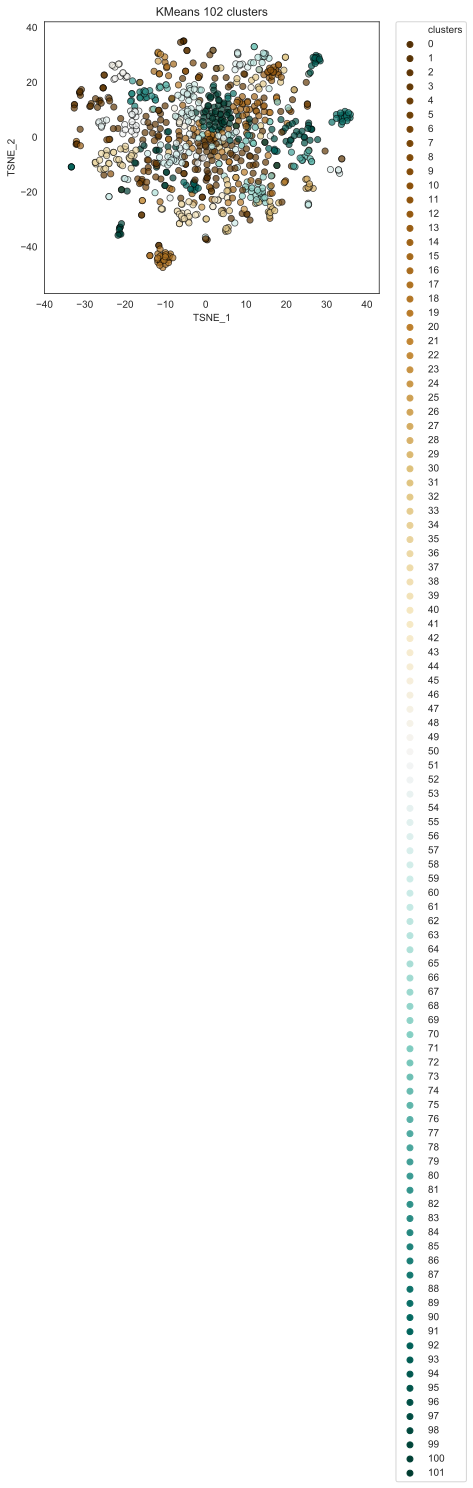

In [70]:
# Plot clustering of clusters
tsne_plot_df = fit_tsne(num_clusters, npr_tfidf_lsa_train.iloc[:, ~npr_tfidf_lsa_train.columns.isin(['labels', 'speaker', 'title', 'labels_sub'])],X_train.iloc[:, ~X_train.columns.isin(['labels', 'speaker', 'title'])], assigned_labels = new_labels)
make_tsne_plot(tsne_plot_df, len(set(split_labels)))#, save_name = 'tsne_kmeans_bestreps_sub'+str(len(set(split_labels)))+'232.svg')


# Supervised Classifier

In [71]:
npr_tfidf_lsa_train2 =  npr_tfidf_lsa_train.iloc[:, ~npr_tfidf_lsa_train.columns.isin(['labels_sub','labels', 'speaker','title'])]
                                           

In [73]:
from sklearn.linear_model import LogisticRegression

gs_params = {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(npr_tfidf_lsa_train2, y_train)
print('TFIDF-LSA', 'Training set score:',lr.score(npr_tfidf_lsa_train2, y_train), 'Test set score:', lr.score(npr_tfidf_lsa_test, y_test) )

y_pred = lr.predict(npr_tfidf_lsa_test)
pd.crosstab(y_pred, y_test, dropna=False)

TFIDF-LSA Training set score: 0.96 Test set score: 0.79


speaker,BRUMFIEL,BURNETT,ELVING,GONZALES,HAMILTON,HARRIS,MARTIN,SHAHANI,SHAPIRO,STEIN
row_0,,,,,,,,,,
BRUMFIEL,17,0,0,0,2,4,0,0,0,0
BURNETT,0,33,1,4,0,0,1,0,2,0
ELVING,0,0,25,0,1,1,2,1,1,0
GONZALES,0,1,0,26,1,1,0,0,0,0
HAMILTON,0,1,0,1,20,3,0,0,1,2
HARRIS,3,0,0,0,3,15,1,0,0,0
MARTIN,0,0,0,0,0,0,30,0,3,0
SHAHANI,0,1,0,2,1,1,1,24,0,0
SHAPIRO,0,2,0,2,0,1,0,0,21,0


In [74]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(npr_tfidf_lsa_train2, y_train)
print('TFIDF-LSA', 'Training set score:',gbc.score(npr_tfidf_lsa_train2, y_train), 'Test set score:', gbc.score(npr_tfidf_lsa_test, y_test) )

y_pred = gbc.predict(npr_tfidf_lsa_test)
pd.crosstab(y_pred, y_test, dropna=False)

TFIDF-LSA Training set score: 1.0 Test set score: 0.76


speaker,BRUMFIEL,BURNETT,ELVING,GONZALES,HAMILTON,HARRIS,MARTIN,SHAHANI,SHAPIRO,STEIN
row_0,,,,,,,,,,
BRUMFIEL,17,0,0,1,3,9,2,0,3,0
BURNETT,0,30,0,2,1,2,0,0,4,0
ELVING,0,0,25,0,1,1,3,0,1,0
GONZALES,0,1,0,30,1,0,0,0,0,0
HAMILTON,0,0,0,0,16,2,0,0,1,2
HARRIS,2,0,0,0,4,14,0,0,1,2
MARTIN,0,0,0,0,0,0,29,0,1,0
SHAHANI,1,2,0,1,0,0,0,25,0,0
SHAPIRO,0,4,1,1,0,1,0,0,18,0


In [75]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(npr_tfidf_lsa_train2, y_train)
print('Doc2Vec', 'Training set score:',svc.score(npr_tfidf_lsa_train2, y_train), 'Test set score:', svc.score(npr_tfidf_lsa_test, y_test) )

y_pred = svc.predict(npr_tfidf_lsa_test)
pd.crosstab(y_pred, y_test, dropna=False)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Doc2Vec Training set score: 0.11 Test set score: 0.07


speaker,BRUMFIEL,BURNETT,ELVING,GONZALES,HAMILTON,HARRIS,MARTIN,SHAHANI,SHAPIRO,STEIN
row_0,,,,,,,,,,
BRUMFIEL,21,38,26,35,31,32,35,25,29,28
